In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset
import torch


df = pd.read_pickle('data_mixing_runs.pkl')
df

FileNotFoundError: [Errno 2] No such file or directory: 'data_mixing_runs.pkl'

In [16]:
# Show first row of categories column
print(df.iloc[0]['categories'])


['RedPajamaWikipedia', 'RedPajamaStackExchange', 'RedPajamaGithub', 'RedPajamaArXiv', 'RedPajamaBook']


In [17]:
df['group'].value_counts()


group
20M     115
300M     73
1B       46
150M     24
500M     20
700M     18
60M      12
Name: count, dtype: int64

In [18]:
df.iloc[0]['history']

,_step,train/CrossEntropyLoss,eval/RedPajamaCommonCrawl/CrossEntropyLoss,eval/RedPajamaC4/CrossEntropyLoss,eval/RedPajamaWikipedia/CrossEntropyLoss,eval/RedPajamaStackExchange/CrossEntropyLoss,eval/RedPajamaGithub/CrossEntropyLoss,eval/RedPajamaArXiv/CrossEntropyLoss,eval/RedPajamaBook/CrossEntropyLoss,eval/downstream/hellaswag_len_norm,eval/downstream/piqa_len_norm,eval/downstream/arc_easy_acc
0,100,4.625463,6.401566,3.339546,3.950630,3.575947,4.192739,5.448653,7.300071,0.256821,0.490751,0.275439
1,200,3.822730,5.648958,2.976440,3.180367,2.873846,3.405788,4.018075,6.249058,0.252241,0.500000,0.289474
2,300,3.178100,5.212800,2.749590,2.703099,2.506079,2.948880,3.468583,5.672214,0.252838,0.511970,0.289474
3,400,2.772161,4.877622,2.602211,2.400005,2.206074,2.523632,2.973908,5.235804,0.256124,0.520131,0.278947
4,500,2.472251,4.724735,2.760540,2.341762,2.085048,2.123425,2.714191,4.931214,0.250846,0.516866,0.284211
...,...,...,...,...,...,...,...,...,...,...,...,...
190,19100,1.259007,2.590483,1.492623,0.975476,0.912545,0.699229,1.435567,2.779317,0.319757,0.626224,0.475439
191,19200,1.247918,2.590946,1.493244,0.975137,0.912417,0.699224,1.435508,2.779187,0.322247,0.630033,0.482456
192,19300,1.257496,2.588971,1.491762,0.975036,0.912100,0.698681,1.435526,2.778788,0.320454,0.624048,0.464912
193,19400,1.222200,2.588932,1.491785,0.974590,0.911804,0.698679,1.435127,2.777934,0.320255,0.622416,0.466667


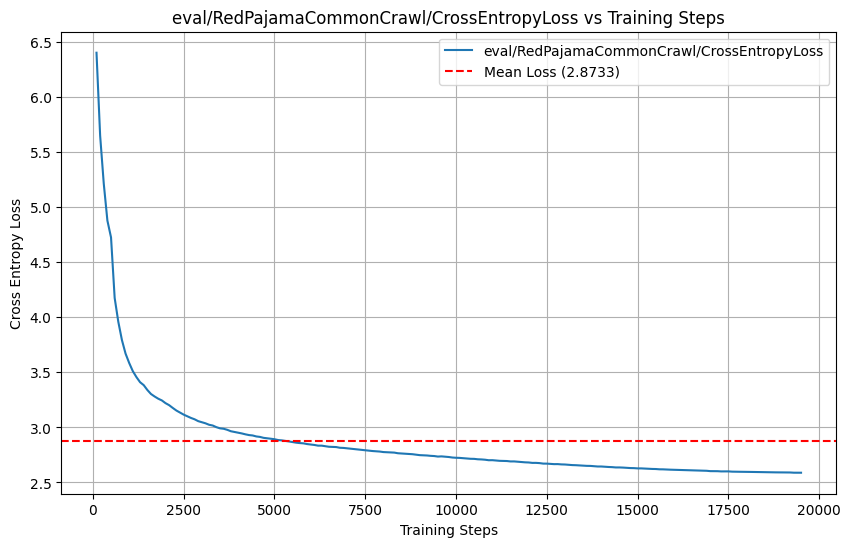

In [19]:
# Plot cross entropy loss for common crawl
import matplotlib.pyplot as plt

# Get first run's history
history = df.iloc[0]['history']

col = 'eval/RedPajamaCommonCrawl/CrossEntropyLoss'

# Calculate mean loss
mean_loss = history[col].mean()

plt.figure(figsize=(10,6))
plt.plot(history['_step'], history[col], label=col)
plt.axhline(y=mean_loss, color='r', linestyle='--', label=f'Mean Loss ({mean_loss:.4f})')
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title(f'{col} vs Training Steps')
plt.grid(True)
plt.legend()
plt.show()

### Data Cleaning

In [20]:
# Prepare input features (X)
# We'll have 9 features now: 5 token probs + 1 encoded group + d_model + n_heads + step
X_list = []
y_list = []

for i in range(len(df)):
    history = df.iloc[i]['history']
    token_probs = df.iloc[i]['token_probabilities']
    group = df.iloc[i]['group']
    # Convert model size string to number 
    if 'B' in group:
        group = float(group.replace('B', '')) * 1000  # Convert B to millions (1B = 1,000M)
    else:
        group = float(group.replace('M', ''))  # Already in millions
    d_model = df.iloc[i]['d_model'] if 'd_model' in df.columns else 0
    n_heads = df.iloc[i]['n_heads'] if 'n_heads' in df.columns else 0
    
    # For each step in history, create an input row
    for _, row in history.iterrows():
        x_row = np.zeros(9)
        x_row[0:5] = token_probs  # First 5: token probabilities
        x_row[5] = group          # 6th: 
        x_row[6] = d_model        # 7th: d_model
        x_row[7] = n_heads        # 8th: n_heads
        x_row[8] = row['_step']   # 9th: step
        
        # Get all columns except '_step' for y
        y_row = row.drop('_step').values
        
        X_list.append(x_row)
        y_list.append(y_row)

# Convert lists to arrays
X = np.array(X_list)
y = np.array(y_list)

In [27]:
X[:, 5]

array([1000., 1000., 1000., ...,  700.,  700.,  700.], shape=(49346,))

### Modular Train/Test Data Split

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os

base_dir='data'

def create_expanded_mask(df, condition_fn):
    """
    Creates an expanded mask that matches the timestep dimension of the data.
    
    Args:
        df: DataFrame containing the data
        condition_fn: Function that takes a row and returns True/False
    """
    expanded_mask = []
    for i in range(len(df)):
        history = df.iloc[i]['history']
        is_condition = condition_fn(df.iloc[i])
        n_steps = len(history)
        expanded_mask.extend([is_condition] * n_steps)
    return np.array(expanded_mask)

def create_billion_mask(df):
    """Creates mask for models >= 1B"""
    return create_expanded_mask(df, lambda row: row['group'] == '1B')

def create_step_mask(X, threshold=15000):
    """Creates mask for steps >= threshold"""
    return X[:, 8] >= threshold

def split_data(X, y, mask):
    """
    Splits data based on a boolean mask
    """
    return (
        X[~mask], X[mask],
        y[~mask], y[mask]
    )

def create_random_split(X, y, test_size=0.2, random_state=42):
    """
    Creates a random train-test split
    """
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

def save_split_data(X_train, X_test, y_train, y_test, split_dir):
    """
    Saves split data to specified directory
    """
    os.makedirs(split_dir, exist_ok=True)
    np.save(os.path.join(split_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(split_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(split_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(split_dir, 'y_test.npy'), y_test)



In [25]:
def create_single_step_split(X, y, step=5000, test_size=0.2, random_state=42):
    """
    Creates train-test split using data from a single training step.
    
    Args:
        X: Feature matrix
        y: Target matrix
        step: The specific step to use for splitting
        test_size: Proportion of data to use for testing
        random_state: Random seed for reproducibility
    """
    # Create mask for the specific step
    step_mask = X[:, 8] == step
    
    # Filter data for just this step
    X_step = X[step_mask]
    y_step = y[step_mask]
    
    # Create random train-test split from the filtered data
    X_train, X_test, y_train, y_test = train_test_split(
        X_step, y_step, 
        test_size=test_size, 
        random_state=random_state
    )
    
    # Save the split
    split_dir = os.path.join('data', f'single_step_{step}_split')
    save_split_data(X_train, X_test, y_train, y_test, split_dir)
    
    print(f"\nSingle Step {step} Split:")
    print(f"Total samples at step {step}: {len(X_step)}")
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    
    return X_train, X_test, y_train, y_test

# Create split for step 5000
X_train, X_test, y_train, y_test = create_single_step_split(X, y, step=15000)


Single Step 15000 Split:
Total samples at step 15000: 228
Train size: 182, Test size: 46


In [ ]:
def create_run_based_splits(df, X, y, num_splits=5, test_runs_per_split=50, random_state=42):
    """
    Creates multiple train-test splits based on run IDs.
    
    Args:
        df: Original DataFrame with run_id column
        X: Feature matrix
        y: Target matrix
        num_splits: Number of different splits to create
        test_runs_per_split: Number of runs to use for testing in each split
        random_state: Random seed for reproducibility
    
    Returns:
        List of dictionaries containing splits
    """
    np.random.seed(random_state)
    unique_runs = df['run_id'].unique()
    splits = []
    
    for split_idx in range(num_splits):
        # Randomly select runs for test set
        test_runs = np.random.choice(unique_runs, size=test_runs_per_split, replace=False)
        
        # Create mask for this split
        run_mask = create_expanded_mask(df, lambda row: row['run_id'] in test_runs)
        
        # Split the data
        X_train, X_test, y_train, y_test = split_data(X, y, run_mask)
        
        # Save the split
        split_dir = os.path.join('data', f'run_{split_idx}_split')
        save_split_data(X_train, X_test, y_train, y_test, split_dir)
        
        # Store split info
        splits.append({
            'split_idx': split_idx,
            'test_runs': test_runs,
            'train_size': len(X_train),
            'test_size': len(X_test),
            'X_train': X_train,
            'X_test': X_test,
            'y_train': y_train,
            'y_test': y_test
        })
        
        print(f"\nRun-based Split {split_idx}:")
        print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
        print(f"Number of test runs: {len(test_runs)}")
    
    return splits

# Create 5 different run-based splits
run_splits = create_run_based_splits(
    df=df,
    X=X,
    y=y,
    num_splits=3,
    test_runs_per_split=50  # Adjust this number based on your needs
)



In [20]:
def create_larger_than_size_splits(df, X, y, base_dir='data'):
    """
    Creates splits where test set contains all models larger than a specific size.
    
    Args:
        df: DataFrame containing the data
        X: Feature matrix
        y: Target matrix
        base_dir: Base directory to save splits
    """
    # All model sizes except 20M (since everything is larger than 20M)
    sizes = ['60M', '150M', '300M', '500M', '700M']
    
    # Helper function to convert size to numeric value in millions
    def size_to_millions(size_str):
        if 'B' in size_str:
            return float(size_str.replace('B', '')) * 1000
        return float(size_str.replace('M', ''))
    
    for threshold_size in sizes:
        threshold_millions = size_to_millions(threshold_size)
        
        # Create mask for models larger than threshold
        size_mask = create_expanded_mask(
            df, 
            lambda row: size_to_millions(row['group']) > threshold_millions
        )
        
        # Split the data
        X_train, X_test, y_train, y_test = split_data(X, y, size_mask)
        
        # Save the split
        split_dir = os.path.join(base_dir, f'size_largerthan_{threshold_size.lower()}_split')
        save_split_data(X_train, X_test, y_train, y_test, split_dir)
        
        # Print split info
        test_sizes = df[df['group'].apply(lambda x: size_to_millions(x) > threshold_millions)]['group'].unique()
        print(f"\nLarger than {threshold_size} Split:")
        print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
        print(f"Test set contains models: {sorted(test_sizes)}")

create_larger_than_size_splits(df, X, y)


Larger than 60M Split:
Train size: 22892, Test size: 26454
Test set contains models: ['150M', '1B', '300M', '500M', '700M']

Larger than 150M Split:
Train size: 25194, Test size: 24152
Test set contains models: ['1B', '300M', '500M', '700M']

Larger than 300M Split:
Train size: 35007, Test size: 14339
Test set contains models: ['1B', '500M', '700M']

Larger than 500M Split:
Train size: 38149, Test size: 11197
Test set contains models: ['1B', '700M']

Larger than 700M Split:
Train size: 40993, Test size: 8353
Test set contains models: ['1B']


In [22]:
def create_larger_than_size_splits(df, X, y, base_dir='data'):
    """
    Creates splits where test set contains ALL data, but train set only contains models smaller than threshold.
    
    Args:
        df: DataFrame containing the data
        X: Feature matrix
        y: Target matrix
        base_dir: Base directory to save splits
    """
    # Helper function to convert size to numeric value in millions
    def size_to_millions(size_str):
        if 'B' in size_str:
            return float(size_str.replace('B', '')) * 1000
        return float(size_str.replace('M', ''))
    
    # All model sizes except 20M (since everything is larger than 20M)
    sizes = ['60M', '150M', '300M', '500M', '700M']
    
    for threshold_size in sizes:
        threshold_millions = size_to_millions(threshold_size)
        
        # Create mask for models SMALLER than threshold (for training)
        train_mask = create_expanded_mask(
            df, 
            lambda row: size_to_millions(row['group']) <= threshold_millions
        )
        
        # Split the data - X_test and y_test contain ALL data
        X_train = X[train_mask]
        y_train = y[train_mask]
        X_test = X  # All data for testing
        y_test = y  # All data for testing
        
        # Save the split
        split_dir = os.path.join(base_dir, f'size_largerthan_{threshold_size.lower()}_split')
        save_split_data(X_train, X_test, y_train, y_test, split_dir)
        
        # Print split info
        train_sizes = df[df['group'].apply(lambda x: size_to_millions(x) <= threshold_millions)]['group'].unique()
        print(f"\nLarger than {threshold_size} Split:")
        print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
        print(f"Train set contains models: {sorted(train_sizes)}")
        print(f"Test set contains all models")

create_larger_than_size_splits(df, X, y)


Larger than 60M Split:
Train size: 22892, Test size: 49346
Train set contains models: ['20M', '60M']
Test set contains all models

Larger than 150M Split:
Train size: 25194, Test size: 49346
Train set contains models: ['150M', '20M', '60M']
Test set contains all models

Larger than 300M Split:
Train size: 35007, Test size: 49346
Train set contains models: ['150M', '20M', '300M', '60M']
Test set contains all models

Larger than 500M Split:
Train size: 38149, Test size: 49346
Train set contains models: ['150M', '20M', '300M', '500M', '60M']
Test set contains all models

Larger than 700M Split:
Train size: 40993, Test size: 49346
Train set contains models: ['150M', '20M', '300M', '500M', '60M', '700M']
Test set contains all models


In [19]:
def create_size_based_splits(df, X, y, base_dir='data'):
    """
    Creates splits based on model sizes, where each size becomes a test set once.
    
    Args:
        df: DataFrame containing the data
        X: Feature matrix
        y: Target matrix
        base_dir: Base directory to save splits
    """
    # All model sizes
    sizes = ['20M', '60M', '150M', '300M', '500M', '700M', '1B']
    
    for test_size in sizes:
        # Create mask for this size
        size_mask = create_expanded_mask(df, lambda row: row['group'] == test_size)
        
        # Split the data
        X_train, X_test, y_train, y_test = split_data(X, y, size_mask)
        
        # Save the split
        split_dir = os.path.join(base_dir, f'size_{test_size.lower()}_split')
        save_split_data(X_train, X_test, y_train, y_test, split_dir)
        
        # Print split info
        print(f"\nSize Split (test size: {test_size}):")
        print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
        print(f"Number of {test_size} runs: {df[df['group'] == test_size].shape[0]}")

create_size_based_splits(df, X, y)


Size Split (test size: 20M):
Train size: 28749, Test size: 20597
Number of 20M runs: 115

Size Split (test size: 60M):
Train size: 47051, Test size: 2295
Number of 60M runs: 12

Size Split (test size: 150M):
Train size: 47044, Test size: 2302
Number of 150M runs: 24

Size Split (test size: 300M):
Train size: 39533, Test size: 9813
Number of 300M runs: 73

Size Split (test size: 500M):
Train size: 46204, Test size: 3142
Number of 500M runs: 20

Size Split (test size: 700M):
Train size: 46502, Test size: 2844
Number of 700M runs: 18

Size Split (test size: 1B):
Train size: 40993, Test size: 8353
Number of 1B runs: 46


In [16]:
# Create splits for different step thresholds
step_thresholds = list(range(2000, 18001, 2000))

for threshold in step_thresholds:
    # Create mask and split data
    step_mask = create_step_mask(X, threshold=threshold)
    X_train, X_test, y_train, y_test = split_data(X, y, step_mask)
    
    # Save split data
    save_split_data(X_train, X_test, y_train, y_test, f'data/step_{threshold}_split')
    
    # Print split sizes
    print(f"\nStep Split > {threshold}:")
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")



Step Split > 2000:
Train size: 5488, Test size: 43858

Step Split > 4000:
Train size: 10966, Test size: 38380

Step Split > 6000:
Train size: 16324, Test size: 33022

Step Split > 8000:
Train size: 21647, Test size: 27699

Step Split > 10000:
Train size: 26869, Test size: 22477

Step Split > 12000:
Train size: 31976, Test size: 17370

Step Split > 14000:
Train size: 36991, Test size: 12355

Step Split > 16000:
Train size: 41524, Test size: 7822

Step Split > 18000:
Train size: 45929, Test size: 3417


In [ ]:
size_dir = os.path.join(base_dir, 'size_split')
random_dir = os.path.join(base_dir, 'random_split')
step_dir = os.path.join(base_dir, 'step_split')

# 1. Size-based split
billion_mask = create_billion_mask(df)
X_train_size, X_test_size, y_train_size, y_test_size = split_data(X, y, billion_mask)
save_split_data(X_train_size, X_test_size, y_train_size, y_test_size, size_dir)

# 2. Random split
X_train_random, X_test_random, y_train_random, y_test_random = create_random_split(X, y)
save_split_data(X_train_random, X_test_random, y_train_random, y_test_random, random_dir)

# 3. Step-based split
step_mask = create_step_mask(X)
X_train_step, X_test_step, y_train_step, y_test_step = split_data(X, y, step_mask)
save_split_data(X_train_step, X_test_step, y_train_step, y_test_step, step_dir)

# Print split sizes
splits_info = {
    "Model Size Split >= 1B": (X_train_size, X_test_size),
    "Random Split 80/20": (X_train_random, X_test_random),
    "Step Split > 15000": (X_train_step, X_test_step)
}

for name, (train, test) in splits_info.items():
    print(f"\n{name}:")
    print(f"Train size: {len(train)}, Test size: {len(test)}")

